<a href="https://colab.research.google.com/github/lingfang23/Take-Home-Challenge/blob/main/A_B_testing_Spanish_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Company XYZ is a worldwide e-commerce site with localized versions of the site.

A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country.

Spain and LatAm country manager suggested that one reason could be translation. All Spanish-speaking countries had the same translation of the site which was written by a Spaniard. Therefore, they agreed to try a test where each country would have its own translation written by a local. 

In [19]:
from google.colab import drive
import pandas as pd
import numpy as np
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
user = pd.read_csv('/content/drive/MyDrive/user_table.csv')
test = pd.read_csv('/content/drive/MyDrive/test_table.csv')

In [21]:
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [22]:
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [23]:
print(user.shape)
print(test.shape)

(452867, 4)
(453321, 9)


In [24]:
print(test['user_id'].nunique()==len(test['user_id']))
print(user['user_id'].nunique()==len(user['user_id']))
print(len(user['user_id']) - len(test['user_id'])) 
# Compare to test table, user data miss some user ids. However, it only accounts for a small portion so it's safe to ged rid of those data

True
True
-454


In [25]:
data = test.merge(user, on=['user_id'])
data.isna().sum()

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271174
browser                  0
conversion               0
test                     0
sex                      0
age                      0
country                  0
dtype: int64

## EDA


In [26]:
data["date"] = pd.to_datetime(data["date"])
data.describe()

,user_id,conversion,test,age
count,452867.000000,452867.000000,452867.000000,452867.000000
mean,499944.805166,0.049560,0.476462,27.130740
std,288676.264784,0.217034,0.499446,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249819.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749543.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


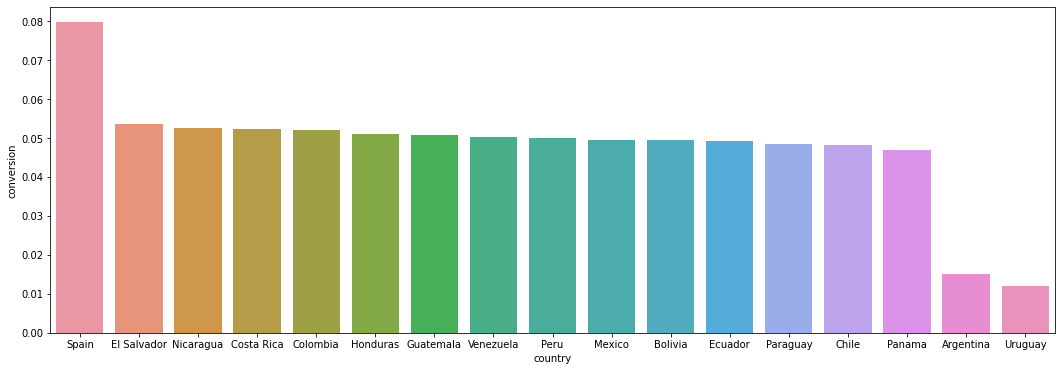

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

groupby_country = data[data['test'] == 0][['conversion', 'country']].groupby('country').mean()
groupby_country = groupby_country.reset_index().sort_values("conversion", ascending = False)

fig, ax = plt.subplots(1,1, figsize=(18,6))
sns.barplot(groupby_country["country"], groupby_country["conversion"],ax=ax)

plt.show()

## T-test


In [28]:
from scipy import stats

df = data[data["country"]!="Spain"]

test = stats.ttest_ind(df[df['test'] == 1]['conversion'], 
                       df[df['test'] == 0]['conversion'], 
                       equal_var=False
                       )

print("p-value", test.pvalue)

p-value 1.9289178577799033e-13


In [29]:
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico


<AxesSubplot:xlabel='date'>

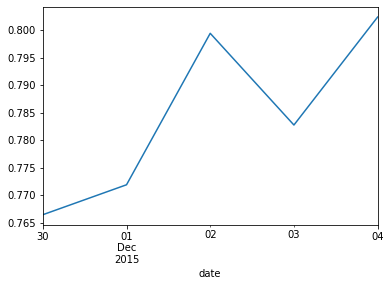

In [30]:
#compare test and control conversion rate by day and plot it
date_c_1 = data[data["test"]==1].groupby("date")["conversion"].mean()
date_c_2 = data[data["test"]==0].groupby("date")["conversion"].mean()

(date_c_1/date_c_2).plot()

In [31]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
  
#make date as string, so few dates that makes sense to have them as few dummy values  
data['date'] = data['date'].apply(str)
  
#make dummy vars. Don't drop one level here, keep them all. You don't want to risk dropping the one level that actually creates problems with the randomization
data_dummy = pd.get_dummies(data)
#model features, test is the label and conversion is not needed 
train_cols = data_dummy.drop(['test', 'conversion'], axis=1)
  
tree=DecisionTreeClassifier(
    #change weights. Our data set is now perfectly balanced. It makes easier to understand the tree output
    class_weight="balanced",
    #only split if if it's worthwhile. The default value of 0 means always split no matter what if you can increase overall performance, which creates tons of noisy and irrelevant splits
    min_impurity_decrease = 0.001
    )
tree.fit(train_cols,data_dummy['test'])
  
export_graphviz(tree, out_file="tree_test.dot", feature_names=train_cols.columns, proportion=True, rotate=True)
s = Source.from_file("tree_test.dot")
s.view()

'tree_test.dot.pdf'

In [32]:
print(data_dummy.groupby("test")[["country_Argentina", "country_Uruguay"]].mean())

      country_Argentina  country_Uruguay
test                                    
0              0.039461         0.001750
1              0.173223         0.017236


In [33]:
original_data = stats.ttest_ind(data_dummy[data['test'] == 1]['conversion'], 
                                data_dummy[data['test'] == 0]['conversion'], 
                                equal_var=False)
  
#this is after removing Argentina and Uruguay
data_no_AR_UR = stats.ttest_ind(data_dummy[(data['test'] == 1) & 
                                           (data_dummy['country_Argentina'] ==  0) & 
                                           (data_dummy['country_Uruguay'] ==  0)
                                           ]['conversion'], 
                                data_dummy[(data['test'] == 0) & 
                                           (data_dummy['country_Argentina'] ==  0) & 
                                           (data_dummy['country_Uruguay'] ==  0)
                                           ]['conversion'], 
                                equal_var=False)
  
print(
pd.DataFrame({"data_type" : ["Full", "Removed_Argentina_Uruguay"], 
                  "p_value" : [original_data.pvalue, data_no_AR_UR.pvalue],
                  "t_statistic" : [original_data.statistic, data_no_AR_UR.statistic]
                 })
)

                   data_type       p_value  t_statistic
0                       Full  1.031210e-74   -18.291393
1  Removed_Argentina_Uruguay  1.296919e-19    -9.061125
